In [1]:
!pip install scvi-tools -U
!pip install scanpy
!pip3 install leidenalg
#!pip install git+https://github.com/theislab/scvelo

     |████████████████████████████████| 231 kB 4.0 MB/s 
     |████████████████████████████████| 678 kB 78.1 MB/s 
     |████████████████████████████████| 213 kB 73.5 MB/s 
     |████████████████████████████████| 813 kB 44.0 MB/s 
     |████████████████████████████████| 91 kB 12.2 MB/s 
     |████████████████████████████████| 242 kB 100.7 MB/s 
     |████████████████████████████████| 829 kB 33.1 MB/s 
     |████████████████████████████████| 329 kB 70.9 MB/s 
     |████████████████████████████████| 132 kB 96.4 MB/s 
     |████████████████████████████████| 636 kB 85.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.5 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 
     |████████████████████████████████| 192 kB 82.2 MB/s 
     |████████████████████████████████| 271 kB 88.2 MB/s 
     |████████████████████████████████| 160 kB 89.7 MB/s 
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19895 sha256=86c4f8c86a11acc0c0be48f5c0d9598b8600b4dec7d50a0e

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import anndata
import seaborn as sns
import matplotlib as mpl
import scvi
#import scvelo as scv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##Start with raw data (initial filtering for low quality cells)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca = sc.read_h5ad('GCA_filtered.h5ad')

In [ ]:
gca.layers['counts'] = gca.X.copy()

In [ ]:
gca_tissue = gca[gca.obs.tissue.isin(['tissue']),:]

In [ ]:
sc.pp.normalize_total(gca_tissue, target_sum=1e4)
sc.pp.log1p(gca_tissue)

gca_tissue.raw = gca_tissue

sc.pp.highly_variable_genes(
    gca_tissue,
    n_top_genes=3000,
    subset=True,
    flavor="seurat")

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
scvi.data.setup_anndata(
    gca_tissue,
    layer="counts",
    categorical_covariate_keys=["sample_id"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 19404 cells, 3000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
model_gca = scvi.model.SCVI(gca_tissue)

In [ ]:
model_gca.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [07:55<00:00,  1.19s/it, loss=256, v_num=1]


In [ ]:
latent = model_gca.get_latent_representation()
gca_tissue.obsm["X_scVI"] = latent

gca_tissue.layers["scvi_normalized"] = model_gca.get_normalized_expression(library_size=10e4)

In [ ]:
sc.pp.neighbors(gca_tissue, use_rep="X_scVI")
sc.tl.leiden(gca_tissue, resolution = 2)
sc.tl.umap(gca_tissue, min_dist = 0.4)

In [ ]:
sc.tl.umap(gca_tissue, min_dist = 0.6)

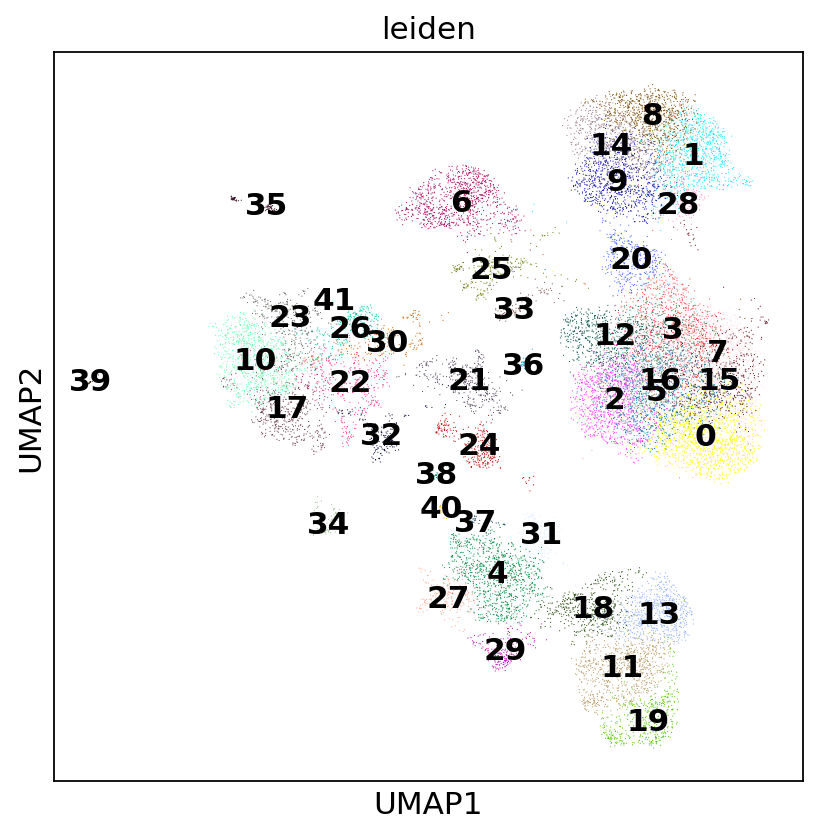

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6]
sc.pl.umap(gca_tissue, color=['leiden'], legend_loc = 'on data', size = 1)

In [ ]:
de_df = model_gca.differential_expression(groupby="leiden")
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
de_df.to_csv('tissue_clustering_stats_leiden.csv')

DE...: 100%|██████████| 42/42 [02:16<00:00,  3.26s/it]


In [ ]:
de_df[(de_df.comparison == '41 vs Rest') & (de_df.non_zeros_proportion1 > 0.25)].head(2)

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2


In [ ]:
gca_tissue.obs['tissue_clustering'] = gca_tissue.obs['leiden']

gca_tissue.obs.replace({'tissue_clustering':'0'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'1'},'MyoFB', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'2'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'3'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'4'},'CD4_2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'5'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'6'},'Endothelium_1', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'7'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'8'},'MyoFB', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'9'},'MyoFB', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'10'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'11'},'CD8', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'12'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'13'},'CD4_1', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'14'},'MyoFB', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'15'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'16'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'17'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'18'},'CD4_1', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'19'},'NK', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'20'},'Transitional', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'21'},'Mac1', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'22'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'23'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'24'},'Mac2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'25'},'Endothelium_2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'26'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'27'},'CD4_2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'28'},'MyoFB', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'29'},'CD4_exhausted', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'30'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'31'},'CD4_2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'32'},'DC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'33'},'Lymph_endo', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'34'},'Plasma', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'35'},'Muscle', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'36'},'VSMC', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'37'},'CD4_2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'38'},'Mac2', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'39'},'Epi', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'40'},'Melanocyte', inplace=True)
gca_tissue.obs.replace({'tissue_clustering':'41'},'Mac1', inplace=True)

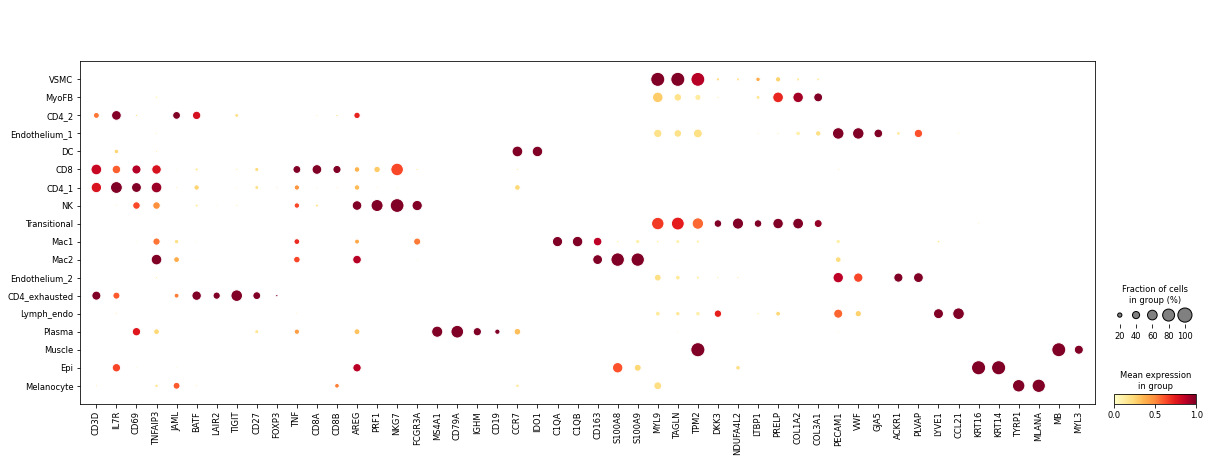

In [ ]:
##include muscle, epithelium and melanocyte markers

sc.pl.DotPlot(gca_tissue, ['CD3D', 'IL7R', 'CD69', 'TNFAIP3',
                           'JAML', 'BATF', 
                           'LAIR2', 'TIGIT', 'CD27', 'FOXP3',
                           'TNF',
                     'CD8A', 'CD8B', 'AREG',    
                     'PRF1', 'NKG7','FCGR3A',
                     'MS4A1', 'CD79A', 'IGHM', 'CD19',
                     'CCR7', 'IDO1',
                     'C1QA', 'C1QB', 'CD163',
                    'S100A8', 'S100A9',
                    'MYL9', 'TAGLN', 'TPM2',
                    'DKK3', 'NDUFA4L2', 'LTBP1',
                    'PRELP', 'COL1A2', 'COL3A1',
                    'PECAM1', 'VWF', 'GJA5',
                    'ACKR1', 'PLVAP',
                    'LYVE1', 'CCL21',
                    'KRT16', 'KRT14',
                    'TYRP1', 'MLANA',
                    'MB', 'MYL3'], 
              groupby = 'tissue_clustering', standard_scale = 'var').style(cmap='YlOrRd',
                                                              dot_edge_color='white', 
                                                    dot_edge_lw=1).show()

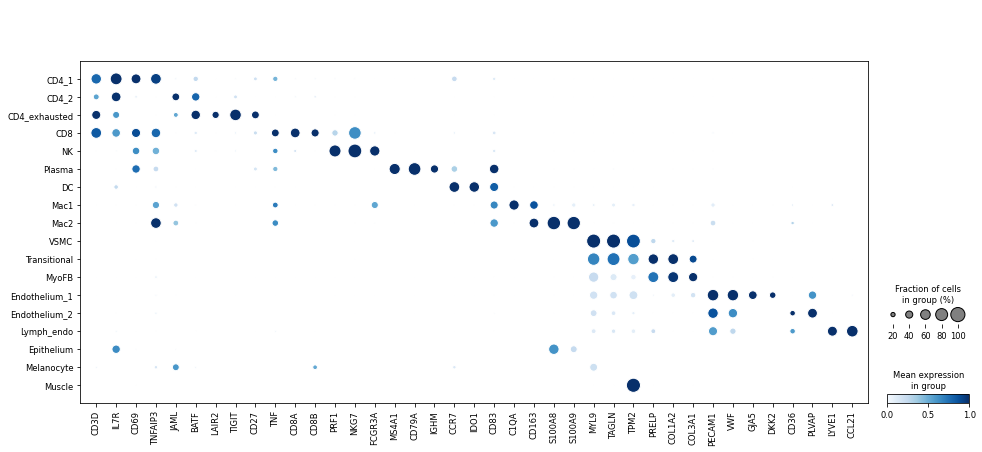

In [ ]:
##don't include muscle, epithelium and melanocyte markers

sc.pl.DotPlot(gca_tissue, ['CD3D', 'IL7R', 
                                    'CD69', 'TNFAIP3',
                           'JAML', 'BATF',

                           'LAIR2', 'TIGIT','CD27', 'TNF',
                     'CD8A', 'CD8B',     
                     'PRF1', 'NKG7','FCGR3A',
                     'MS4A1', 'CD79A', 'IGHM', 
                     'CCR7', 'IDO1', 'CD83',
                     'C1QA', 'CD163',
                    'S100A8', 'S100A9',
                    'MYL9', 'TAGLN', 'TPM2',
              
                    'PRELP', 'COL1A2', 'COL3A1',
                    'PECAM1', 'VWF', 
                    'GJA5','DKK2',
                    'CD36', 'PLVAP',
                    'LYVE1', 'CCL21'], 
              groupby = 'tissue_clustering', standard_scale = 'var').style(cmap='Blues',
                                                              dot_edge_color='white', 
                                                    dot_edge_lw=1).show()

In [ ]:
#calculate DEGs between new clusters

de_df = model_gca.differential_expression(groupby="tissue_clustering")
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
de_df.to_csv('tissue_clustering_stats_post_clustering.csv')

DE...: 100%|██████████| 18/18 [01:00<00:00,  3.37s/it]


In [ ]:
#checkpoint - initial clustering of tissue data

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data')
model_gca.save("tissue_model/", overwrite = True, save_anndata = True)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca_tissue.write('GCA_tissue.h5ad', compression = 'gzip')

Restart after initial clustering

In [4]:
##Restart
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/datasets')
gca_tissue = sc.read_h5ad('GCA_tissue.h5ad')
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data')
model_gca = scvi.model.SCVI.load("tissue_model_v1/", gca_tissue, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs']                        
INFO     Successfully registered anndata object containing 20757 cells, 3000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#export this clustering to be appended to the full dataset

os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
gca_tissue.obs[['tissue_clustering']].to_csv('tissue_clustering.csv')

In [20]:
gca_tissue_filtered = gca_tissue[~gca_tissue.obs.tissue_clustering.isin(['Doublet']),:]

In [21]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/')
colours = pd.read_csv('colours_tissue.csv', index_col = 0)

gca_tissue_filtered.obs.tissue_clustering = gca_tissue_filtered.obs.tissue_clustering.astype(str) + '_tissue'
gca_tissue_filtered.obs.tissue_clustering = gca_tissue_filtered.obs.tissue_clustering.astype('category')

#reorder categories using colour csv

gca_tissue_filtered.obs.tissue_clustering = gca_tissue_filtered.obs.tissue_clustering.cat.reorder_categories(colours[colours.anno.str.contains('_tissue')].anno.tolist())

#add colour using colour csv

gca_tissue_filtered.uns['tissue_clustering_colors'] = np.array(colours[colours.anno.str.contains('_tissue')].colors.tolist())

Trying to set attribute `.obs` of view, copying.


In [22]:
gca_tissue_filtered = gca_tissue_filtered[~gca_tissue_filtered.obs.tissue_clustering.isin(['Melanocyte_tissue', 'Muscle_tissue', 'Epi_tissue']),:]

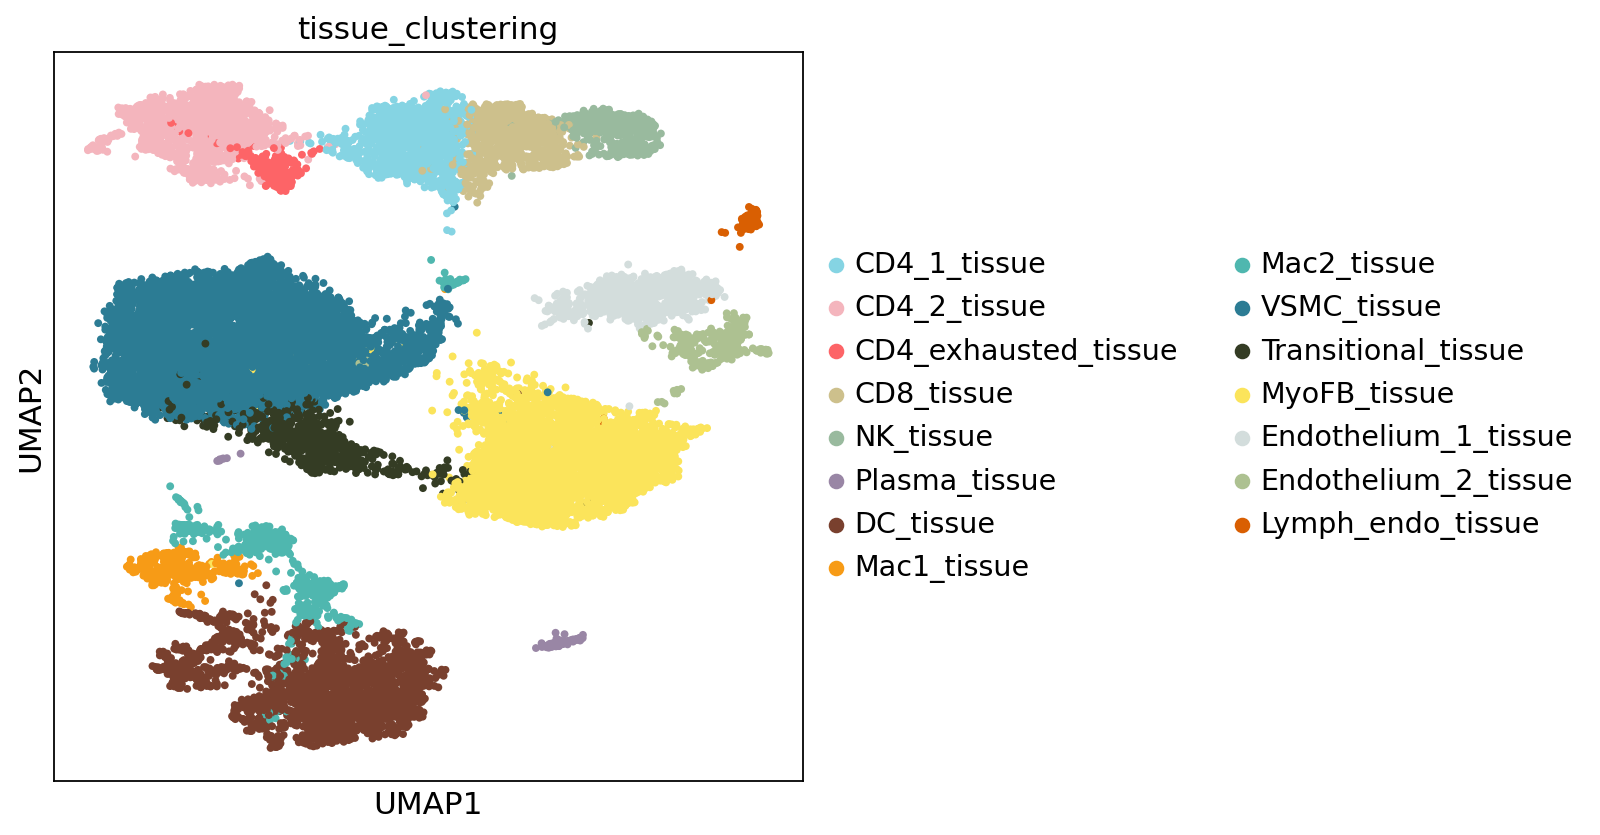

In [23]:
sc.set_figure_params(dpi=80, dpi_save = 300)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

plt.rcParams['figure.figsize'] = [6, 6]
sc.pl.umap(gca_tissue_filtered, color=['tissue_clustering'], legend_loc = 'right margin', size = 50, 
           )

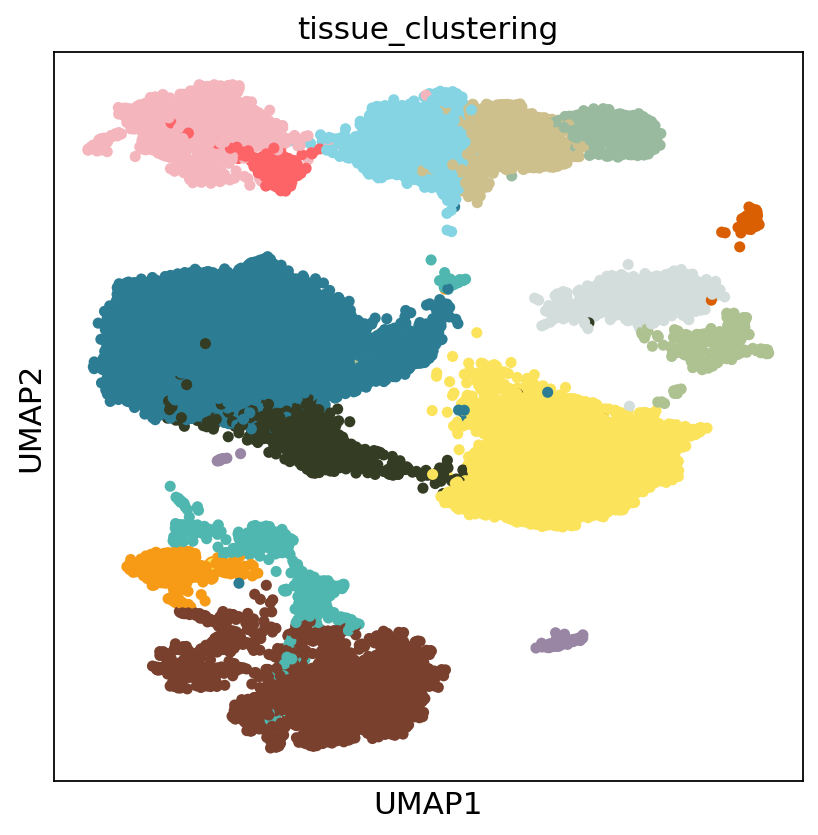

In [ ]:
sc.set_figure_params(dpi=80, dpi_save = 300)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

plt.rcParams['figure.figsize'] = [6, 6]
sc.pl.umap(gca_tissue_filtered, color=['tissue_clustering'], legend_loc = '', size = 100, 
          save = 'tissue_clusters_umap.png'
           )

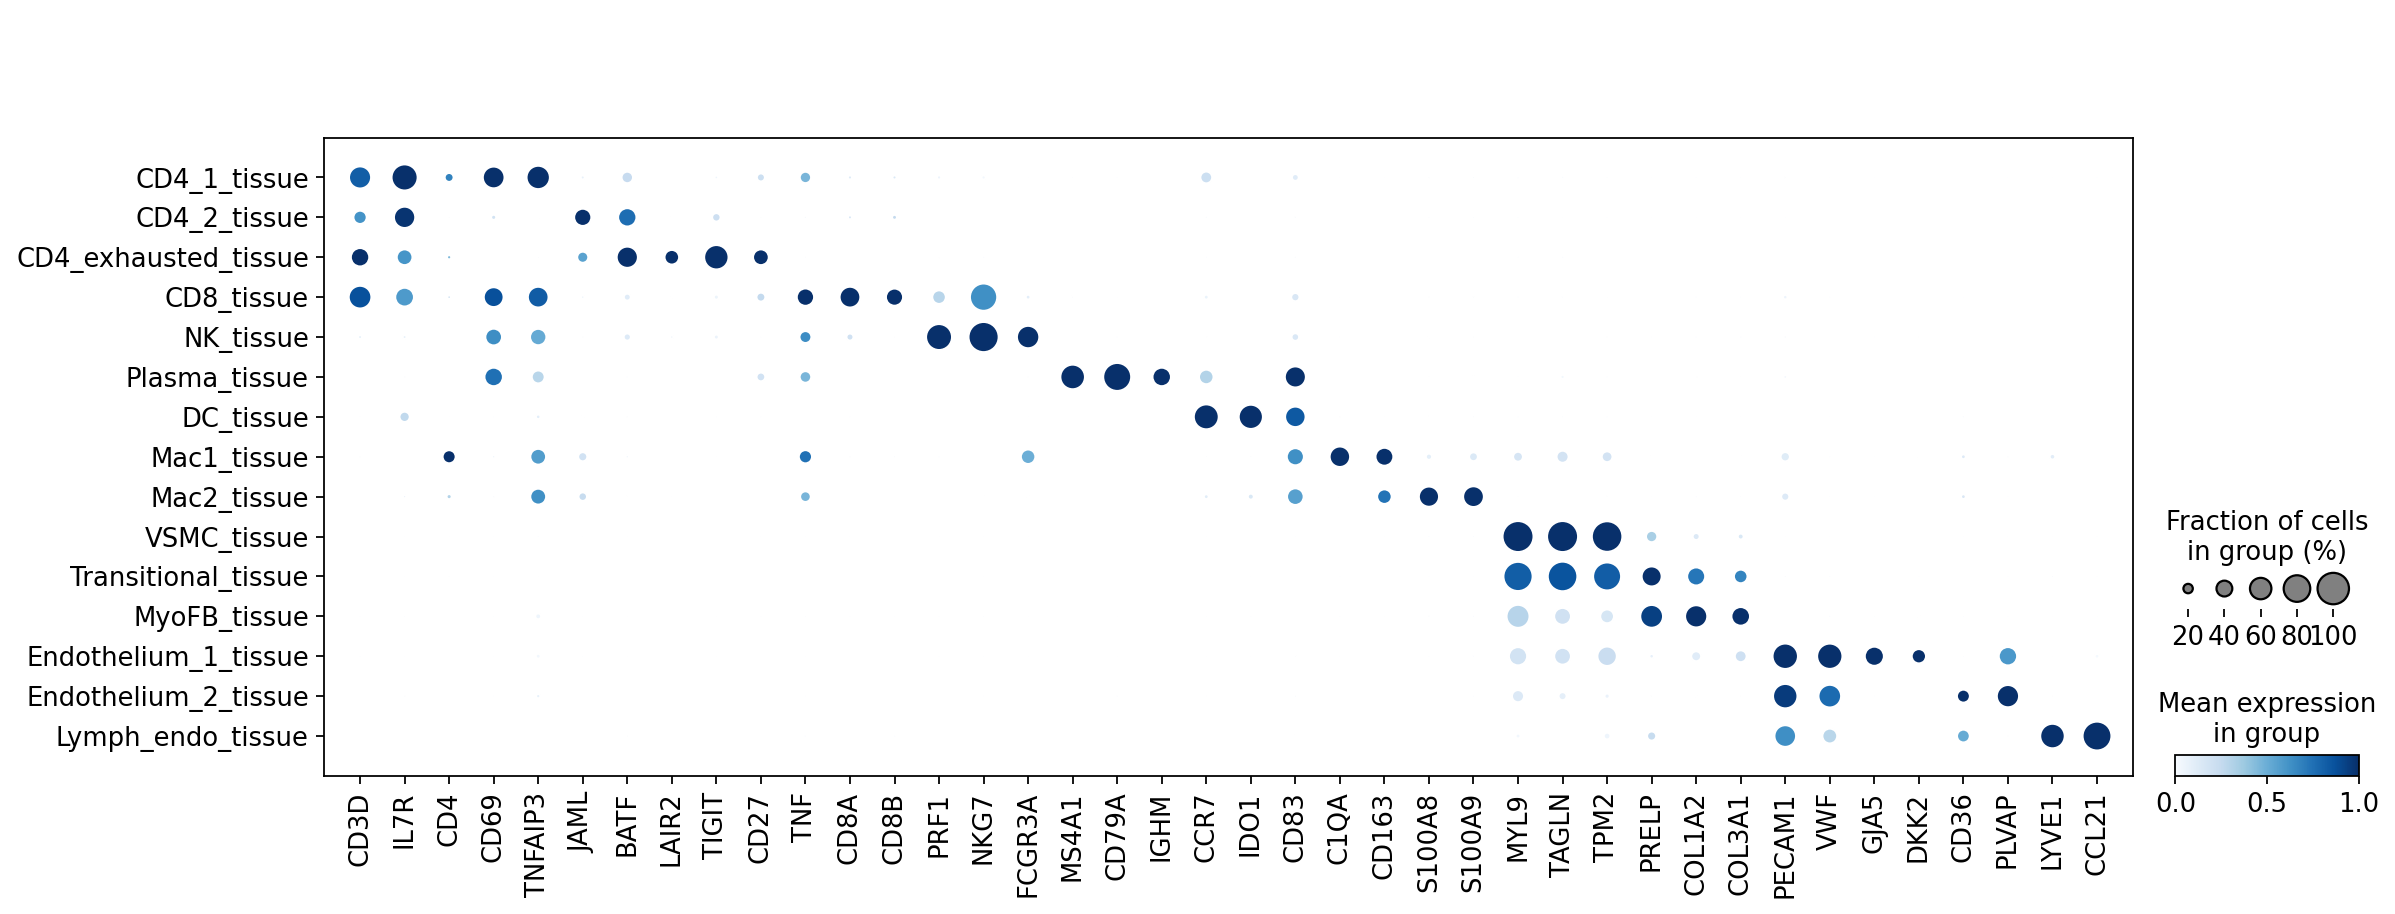

In [24]:
sc.set_figure_params(dpi=80, dpi_save = 300)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.pl.DotPlot(gca_tissue_filtered, ['CD3D', 'IL7R', 'CD4', 
                                    'CD69', 'TNFAIP3',
                           'JAML', 'BATF',

                           'LAIR2', 'TIGIT','CD27', 'TNF',
                     'CD8A', 'CD8B',     
                     'PRF1', 'NKG7','FCGR3A',
                     'MS4A1', 'CD79A', 'IGHM', 
                     'CCR7', 'IDO1', 'CD83',
                     'C1QA', 'CD163',
                    'S100A8', 'S100A9',
                    'MYL9', 'TAGLN', 'TPM2',
              
                    'PRELP', 'COL1A2', 'COL3A1',
                    'PECAM1', 'VWF', 
                    'GJA5','DKK2',
                    'CD36', 'PLVAP',
                    'LYVE1', 'CCL21'], 
              groupby = 'tissue_clustering', standard_scale = 'var').style(cmap='Blues',
                                                              dot_edge_color='white', 
                                                    dot_edge_lw=1).savefig('tissue_clustering_dotplot.png')

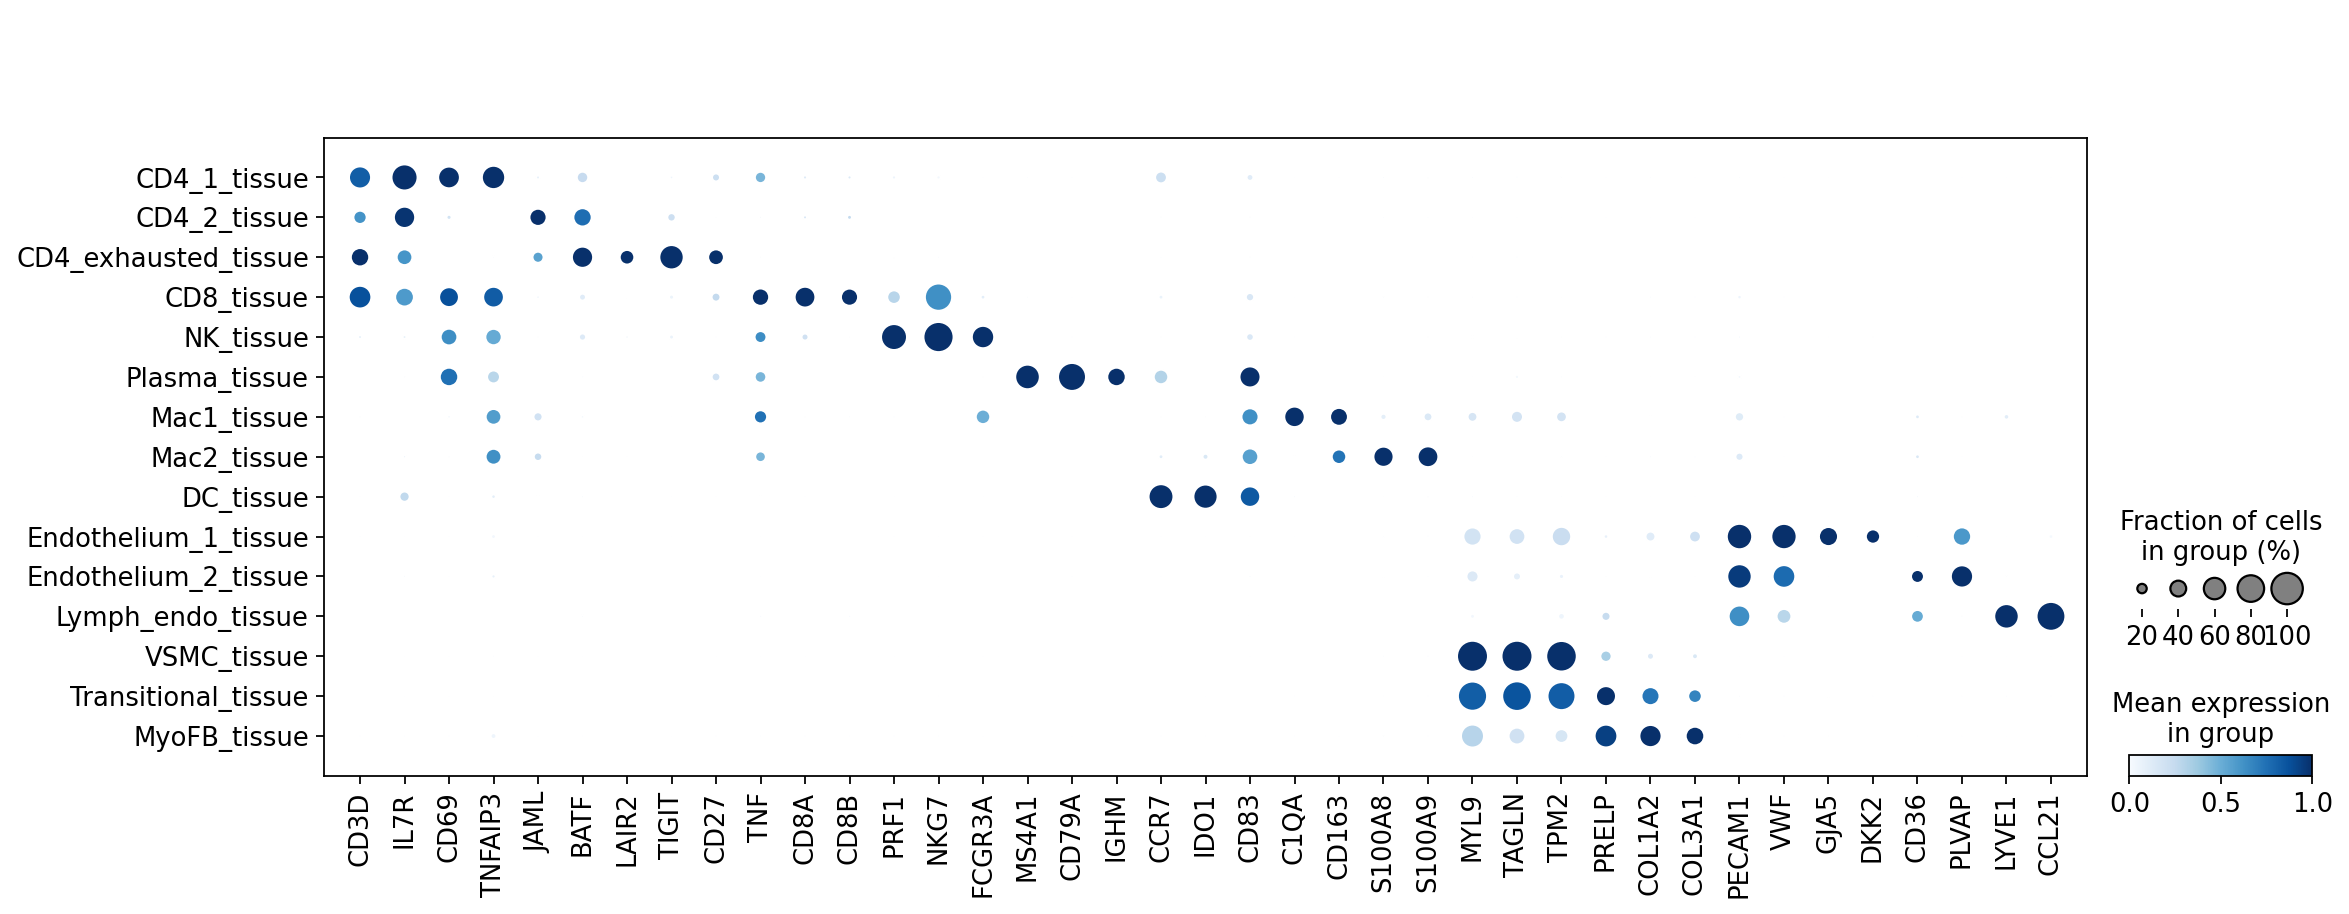

In [ ]:
sc.set_figure_params(dpi=80, dpi_save = 300)
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/figures')

sc.pl.DotPlot(gca_tissue_filtered, ['CD3D', 'IL7R', 
                                    'CD69', 'TNFAIP3',
                           'JAML', 'BATF',

                           'LAIR2', 'TIGIT','CD27', 'TNF',
                     'CD8A', 'CD8B',     
                     'PRF1', 'NKG7','FCGR3A',
                     'MS4A1', 'CD79A', 'IGHM', 
                     'CCR7', 'IDO1', 'CD83',
                     'C1QA', 'CD163',
                    'S100A8', 'S100A9',
                    'MYL9', 'TAGLN', 'TPM2',
              
                    'PRELP', 'COL1A2', 'COL3A1',
                    'PECAM1', 'VWF', 
                    'GJA5','DKK2',
                    'CD36', 'PLVAP',
                    'LYVE1', 'CCL21'], 
              groupby = 'tissue_clustering', standard_scale = 'var').style(cmap='Blues',
                                                              dot_edge_color='white', 
                                                    dot_edge_lw=1).savefig('tissue_clustering_dotplot.png')

In [ ]:
gca_tissue.obs.n_genes_by_counts.min()

9

In [ ]:
temp = gca_tissue_filtered[gca_tissue_filtered.obs.tissue_clustering == 'MyoFB_tissue',:]

In [ ]:
gca_tissue.obs['combined'] = gca_tissue.obs.tissue_clustering.astype(str) + '_' + gca_tissue.obs.diagnosis.astype(str)

In [ ]:
gca_tissue.obs.tissue_clustering = gca_tissue.obs.tissue_clustering.astype('category')

In [ ]:
de_df = model_gca.differential_expression(groupby="combined", group1 = 'MyoFB_positive', group2 = 'MyoFB_negative')


DE...: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


In [ ]:
de_df = pd.DataFrame()

for i in gca_tissue.obs.tissue_clustering.cat.categories:
  de_df_temp = model_gca.differential_expression(groupby="combined", group1 = (i + '_positive'), group2 = (i + '_negative'))
  de_df = de_df.append(de_df_temp)

DE...: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


In [ ]:
os.chdir('/content/drive/MyDrive/jupyterdata/GCA_data/stats')
de_df.to_csv('DEGs_scVI_negative_vs_positive_diagnosis.csv')